In [1]:
# I compiled this code on a windows system. The following code will supress windows specific warnings.
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import dcl_clean_tweets

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
twitter = pd.read_csv("Tweets.csv")

Please have a look at this image before getting into the *dcl_clean_tweets.py* script
<img src="images/sa.png" align='middle' height="300" width="300"/>

In [6]:
# please look into the clean tweeets code for more
cleaned_tweets = dcl_clean_tweets.clean_tweets(n_threads=14)

completed in =  2.2316060066223145


#### Creating the Bag of Words frequency counts

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def get_tf_idf(df, text_field ='text', sent_field="airline_sentiment"):
    # creating bag of words freq counts post tokenizing
    count_vect = CountVectorizer()
    X_bog = count_vect.fit_transform(df[text_field])

    # creating the tf-idf vectors. 
    tf_transformer = TfidfTransformer(norm='l2')
    X = tf_transformer.fit_transform(X_bog)
    y = df[sent_field]
    return X, y

In [8]:
twitter['cleaned_tweets'] = cleaned_tweets

In [9]:
twitter_cp = twitter[twitter.airline_sentiment != 'neutral']

In [11]:
X, y = get_tf_idf(twitter_cp, "text", "airline_sentiment")

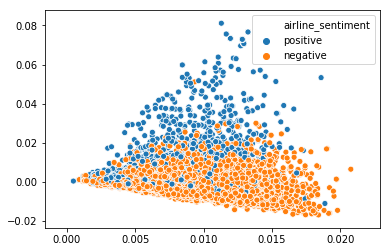

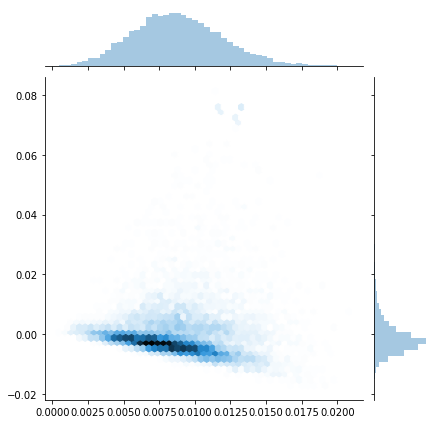

In [12]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=2, n_iter=7, random_state=4)
pca.fit_transform(X.T)
sns.scatterplot(x=pca.components_[0], y=pca.components_[1], hue=y)
sns.jointplot(x=pca.components_[0], y=pca.components_[1], kind="hex")

## Model training

In [13]:
# general methods for calculating the precision and recall
def calculate_precision(conf_matrix):
    conf_matrix = np.array(conf_matrix)
    prec_ = 0
    n = len(conf_matrix)
    for col in range(n):
        prec_ += (conf_matrix[col][col] / (np.sum(conf_matrix[:,col])))
    prec_ /= n
    return prec_

def calculate_recall(conf_matrix):
    conf_matrix = np.array(conf_matrix)
    rec_ = 0
    n = len(conf_matrix)
    for col in range(n):
        rec_ += (conf_matrix[col][col] / (np.sum(conf_matrix[col, :])))
    rec_ /= n
    return rec_

def calculate_f1_score(prec, recall):
    return ((2*prec*recall)/(prec+recall))

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9233434387180598

In [97]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
sgd = SGDClassifier(loss = 'log')
rfc = RandomForestClassifier()
knn = KNeighborsClassifier(n_neighbors=11)
per = Perceptron(tol=1e-3, random_state=0)

clfs = {"DecisionTreeClassifier" : dtree, 
        "SGDClassifier" : sgd, 
        "RandomForestClassifier" : rfc, 
        "KNeighborsClassifier" : knn,
        "Perceptron" : per
       }
nu_folds = 5

In [18]:
y = y.map({"positive":1, "negative":0})

In [98]:
from sklearn.model_selection import KFold
from itertools import tee
from sklearn.metrics import confusion_matrix, accuracy_score

kfolds = KFold(n_splits=nu_folds)
train_test_spl = kfolds.split(X)
mean_acc = []
print('running for ',len(clfs),' classifiers and ',str(nu_folds)+" folds.")
for key, clf in clfs.items():
    sum_acc_ = 0
    sum_f1_ = 0
    train_test_spl, train_test_spl_cp = tee(train_test_spl)
    print("working on = ", key)
    for e in train_test_spl:
        y = np.array(y)
        sub_x = X[e[0],:]
        sub_y = ((y))[e[0]]
        clf.fit(sub_x, sub_y)
        y_pred = clf.predict(X[e[1]])
        
        conf = confusion_matrix(y[e[1]], y_pred)
        rec_ = calculate_recall(conf)
        pre_ = calculate_precision(conf)
        f1_sc_ = calculate_f1_score(pre_, rec_)
        acc_ = accuracy_score(y[e[1]], y_pred)
        
        sum_f1_ += f1_sc_
        sum_acc_ += acc_
        print("====>",end='')
    print(" ",key, "Done")
    mean_acc.append((key,sum_f1_/nu_folds, sum_acc_/nu_folds))
    train_test_spl = train_test_spl_cp
    

print("\nMETRICS SUMMARY")
print("\nClassifier, F1, ACC")
print(*mean_acc, sep='\n')
best_acc = max(mean_acc, key=lambda x : x[2])
best_f1 = max(mean_acc, key=lambda x : x[1])
print("\n ************************** \n Best classifier - ", best_acc[0] , " with accuracy = " ,best_acc[2])
print("\n ************************** \n Best classifier - ", best_acc[0] , " with f1-score = " ,best_acc[1])

running for  5  classifiers and  5 folds.
working on =  DecisionTreeClassifier
====>====>====>====>====>  DecisionTreeClassifier Done
working on =  SGDClassifier
====>====>====>====>====>  SGDClassifier Done
working on =  RandomForestClassifier
====>====>====>====>====>  RandomForestClassifier Done
working on =  KNeighborsClassifier
====>====>====>====>====>  KNeighborsClassifier Done
working on =  Perceptron
====>====>====>====>====>  Perceptron Done

METRICS SUMMARY

Classifier, F1, ACC
('DecisionTreeClassifier', 0.7589485280831572, 0.855124923721734)
('SGDClassifier', 0.8257783859255904, 0.8954163986450429)
('RandomForestClassifier', 0.7627037820583638, 0.863356446367278)
('KNeighborsClassifier', 0.8217529660377, 0.8916045119204259)
('Perceptron', 0.837340237818284, 0.9010492812016576)

 ************************** 
 Best classifier -  Perceptron  with accuracy =  0.9010492812016576

 ************************** 
 Best classifier -  Perceptron  with f1-score =  0.837340237818284
